In [1]:
import pandas as pd
import numpy as np

df_all = pd.read_csv('Ngrams_docs.csv')

texty_ = df_all.values.tolist()
texty_1 = [i[0] for i in texty_]

In [3]:
import gensim
from gensim.corpora import Dictionary
tokenized_text = []
for j in texty_:
    tokenized_text.append(j[0].split())

### Bag Of Words

In [4]:
dictionary = gensim.corpora.Dictionary(tokenized_text)
dictionary.filter_extremes(no_below=20, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_text]

### Latent Dirichlet Allocation 

In [5]:
from gensim import corpora, models

lda_model = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics=8, id2word=dictionary,update_every=1,alpha='auto',per_word_topics=True, passes=10)

from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6574525475073519


In [6]:
def compute_coherence_values(dictionary, bow_corpus, tokenized_text, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:

    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        #model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary)
        model = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary,update_every=1,alpha='auto',per_word_topics=True, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=tokenized_text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

from gensim.models import CoherenceModel
model_list, coherence_values = compute_coherence_values(dictionary, bow_corpus, tokenized_text, start=6, limit=20, step=2)

import matplotlib.pyplot as plt

limit=20; start=6; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### pyLDAvis Visualization

In [7]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [8]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.041*"grain" + 0.026*"porosity" + 0.018*"quartz" + 0.016*"clay" + 0.016*"cement" + 0.011*"fine" + 0.010*"present" + 0.010*"calcite" + 0.010*"authigenic" + 0.009*"sandstone"
Topic: 1 
Words: 0.026*"sand" + 0.023*"mineral" + 0.019*"gas" + 0.018*"permeability" + 0.017*"connection_report" + 0.015*"report" + 0.015*"use" + 0.015*"core_laboratories_canada_ltd" + 0.014*"core" + 0.011*"use_rely_upon"
Topic: 2 
Words: 0.018*"gas" + 0.011*"zone" + 0.011*"hydrocarbon" + 0.010*"oil" + 0.009*"datum" + 0.009*"pressure" + 0.008*"cd" + 0.008*"analysis" + 0.007*"interval" + 0.007*"use"
Topic: 3 
Words: 0.019*"hole" + 0.017*"drill" + 0.014*"run" + 0.013*"cement" + 0.009*"pressure" + 0.009*"mud" + 0.009*"bit" + 0.008*"section" + 0.008*"pkg" + 0.008*"case"
Topic: 4 
Words: 0.113*"pct" + 0.059*"fine" + 0.036*"grain" + 0.032*"trace" + 0.024*"comment" + 0.024*"material" + 0.022*"calcareous" + 0.021*"silt" + 0.020*"size_mode_sand" + 0.019*"argillaceous"
Topic: 5 
Words: 0.032*"fine" + 0.029*"

C:\Users\gouth\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Dominent Topic

In [9]:
def format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=tokenized_text):
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
    
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=tokenized_text)

C:\Users\gouth\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['File_No', 'Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic[0:]

C:\Users\gouth\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,File_No,Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9459,"hole, drill, run, cement, pressure, mud, bit, ...","[write, fluids, discussion, classification, dr..."
1,1,3.0,0.5233,"hole, drill, run, cement, pressure, mud, bit, ...","[well, history, extensive, evaluation, conduct..."
2,2,5.0,0.9270,"fine, sandstone, grey, trace, grain, calcareou...","[per_canada, al, co_asset, dark, gray, shale, ..."
3,3,4.0,0.7594,"pct, fine, grain, trace, comment, material, ca...","[reddish_brown, pct, silt, pct, calcareous, so..."
4,4,4.0,0.5358,"pct, fine, grain, trace, comment, material, ca...","[absolve, permitted, record, alec, afe, slim, ..."
...,...,...,...,...,...
2793,2793,3.0,0.9862,"hole, drill, run, cement, pressure, mud, bit, ...","[cut, run, combination, case, cement, neat, ce..."
2794,2794,2.0,0.6992,"gas, zone, hydrocarbon, oil, datum, pressure, ...","[shoot, summary, listing, perform, aug, status..."
2795,2795,3.0,0.9877,"hole, drill, run, cement, pressure, mud, bit, ...","[sonic, run, gr, bottom, string, sonic, centra..."
2796,2796,2.0,0.7454,"gas, zone, hydrocarbon, oil, datum, pressure, ...","[tho, teflon, standoffs, cauliflower, bullnose..."


### Word Clouds

C:\Users\gouth\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


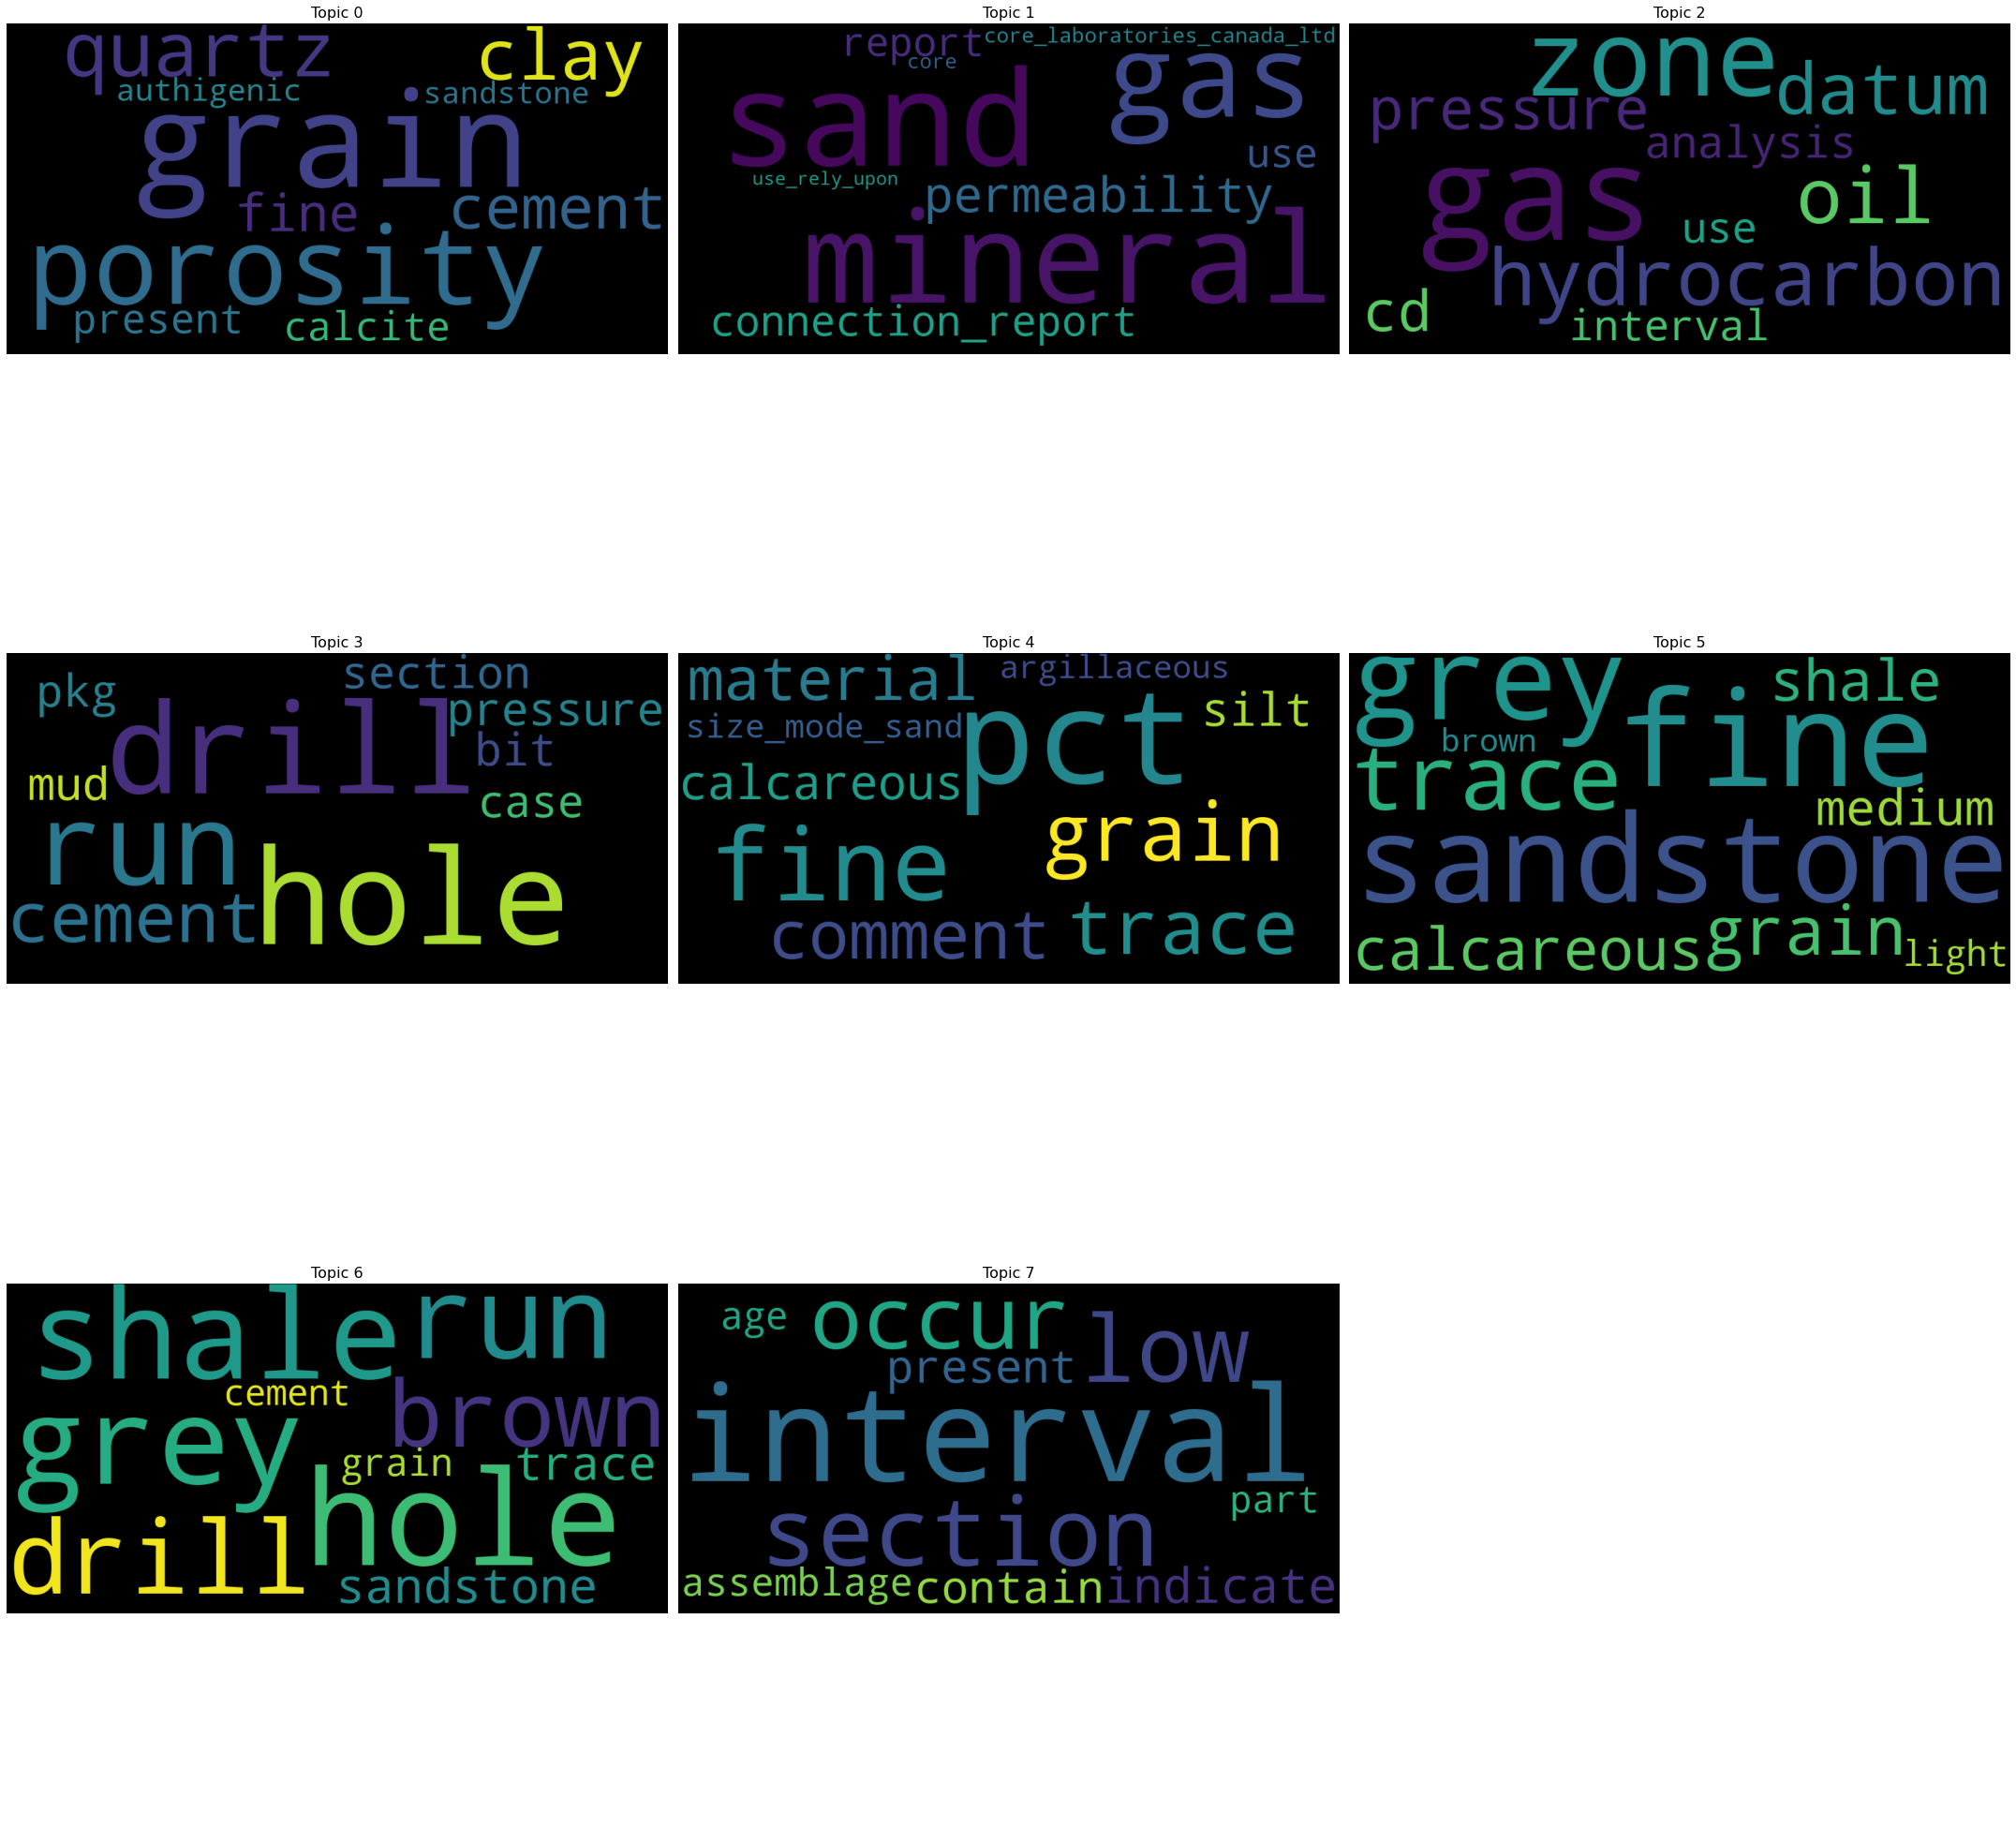

In [11]:
pd.options.display.max_seq_items = 2000
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import math

#cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(width=1000,
                  height=500,
                  #max_words=15,
                  #colormap='tab10',
                  #color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(math.ceil(len(topics)/3), 3, figsize=(30,30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    if i < len(topics):
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=200)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### BERTopic Model

In [12]:
from bertopic import BERTopic

C:\Users\gouth\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
df_all = pd.read_csv(r'C:\Users\gouth\OneDrive\Desktop\Dalhousie\Thesis\WESI\Untitled Folder\Entire data\New_data\FINAL_LIST.csv')

data_ = df_all.values.tolist()
texty_2 = [i[1] for i in data_]

C:\Users\gouth\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\gouth\Anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [29]:
t_model = BERTopic(language="english")

topics, probabilities = t_model.fit_transform(texty_1)

t_model.get_topic_freq()

,Topic,Count
0,-1,535
1,34,172
2,45,122
3,41,110
4,32,86
...,...,...
70,30,11
71,73,11
72,63,10
73,53,10


In [30]:
for i in t_model.get_topic_freq()['Topic'].values.tolist()[1:11]:
    print(t_model.get_topic(i))

[('moncrystallinequartz', 0.0009283926513150345), ('planpolarizelight', 0.0006775226793954946), ('photographplanpolarizelight', 0.0005995229686421189), ('sublithicarsenite', 0.0005876119949018103), ('authigenicquartzovergrowth', 0.0005732636848159653), ('lithiclast', 0.0005726192497939053), ('fieldviewphotographplan', 0.0005593752487471324), ('crossepolarizelight', 0.0005558577239763979), ('purposeaccessinformationact', 0.0005333944071173067), ('polarizelightcrossepolarize', 0.00053010455421587)]
[('forecastverificationreportamen', 0.00270225074140111), ('fosterwheelerprojectdecember', 0.0023309651776482073), ('quartzcrystalgrowth', 0.002151401501682256), ('cheshirelaphysicalenvironmental', 0.0018472921113841976), ('reportamenfosterwheeler', 0.0015833980222573708), ('cheshiretrykhz', 0.0013583992147053324), ('fieldprocedure', 0.001353869914683648), ('projectdecember', 0.0013343438025678355), ('addstatisticalsummary', 0.0012401364013454779), ('calibratevelocity', 0.0012099133321164701)]

In [16]:
t_model.get_topic(1)

C:\Users\gouth\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('correctness', 0.08902846720624119),
 ('electronics', 0.05208869795385947),
 ('expense', 0.0502702775889689),
 ('responsible', 0.04699387307305375),
 ('accuracy', 0.0447300424475026),
 ('wilful', 0.04427700346917229),
 ('negligence', 0.0370118946418859),
 ('liable', 0.031813754365648976),
 ('calibration', 0.02846545188135248),
 ('damage', 0.010114834311139949)]

### Top2Vec Model

In [20]:
from top2vec import Top2Vec

top2vec_model = Top2Vec(documents = texty_1, speed="learn", workers=8)

2021-05-10 06:20:16,160 - top2vec - INFO - Pre-processing documents for training
2021-05-10 06:20:56,043 - top2vec - INFO - Creating joint document/word embedding
2021-05-10 06:31:29,176 - top2vec - INFO - Creating lower dimension embedding of documents
2021-05-10 06:31:53,267 - top2vec - INFO - Finding dense areas of documents
2021-05-10 06:31:53,466 - top2vec - INFO - Finding topics


In [21]:
top2vec_model.get_num_topics()

41

In [22]:
topic_sizes, topic_nums = top2vec_model.get_topic_sizes()

In [23]:
topic_sizes

array([308, 244, 216, 116, 111, 110,  93,  88,  85,  78,  70,  70,  65,
        64,  58,  57,  56,  54,  54,  52,  50,  47,  46,  44,  43,  38,
        38,  37,  36,  36,  36,  34,  34,  33,  31,  30,  29,  28,  28,
        27,  24], dtype=int64)

In [24]:
topic_nums

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40], dtype=int64)

In [27]:
topic_words, word_scores, topic_nums = top2vec_model.get_topics(8)

In [28]:
topic_words

array([['assemblage', 'dinoflagellate', 'din_cyst', 'terrestrial',
        'paly_morph', 'specie', 'diversity', 'spore_pollen',
        'paly_morphs', 'species', 'taxa', 'eocene', 'micro_plankton',
        'marginal_marine', 'maastricht', 'paly_logical', 'occurrence',
        'kerogen', 'shallow_marine', 'bathyal', 'fauna', 'flora',
        'albion', 'presence', 'organic_carbon', 'barren', 'environment',
        'pollen', 'campania', 'def_andrea', 'paleocene', 'maturation',
        'cretaceous', 'age', 'maturity', 'kerogen_type', 'apt_ian',
        'strata', 'oligocene', 'spore', 'sediment', 'situ', 'vitrinite',
        'late_cretaceous', 'analyse', 'extract', 'palynology',
        'deposition', 'micro_fauna', 'global_duncan'],
       ['cubic_metre_gas', 'oil_cubic_metre', 'cubic_metre_oil',
        'tank_oil', 'per_cubic_metre', 'file_number', 'reservoir_fluid',
        'spa_gauge', 'cubic_metre', 'gentleman', 'distillation',
        'summarize_page', 'cubic_foot_gas', 'liquid', 'sepa

### LSA Model

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
 # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(texty_1)

In [42]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

In [45]:
len(svd_model.components_[0])

52684

In [46]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
fine
 
grey
 
grain
 
sandstone
 
shale
 
trace
 
calcareous
 
Topic 1: 
case_gross_wilful_negligence
 
part_liable_responsible
 
electrical_measurement_guarantee_accuracy
 
correctness_interpretation_shall_except
 
interpretation_opinion_base_inference
 
interpretation_make_officer
 
agent_employee_interpretation
 
Topic 2: 
hole
 
drill
 
run
 
pressure
 
test
 
gas
 
bit
 
Topic 3: 
pct
 
size_mode_sand
 
comment
 
material
 
fine
 
silt
 
permeability
 
Topic 4: 
gas
 
indicate
 
pressure_temperature_per
 
oil
 
hydrocarbon
 
cubic_metre_gas
 
spa_absolute_per_cubic
 
Topic 5: 
pressure_temperature_per
 
cubic_metre_gas
 
spa_absolute_per_cubic
 
pressure
 
indicate
 
cubic_metre_residual_oil
 
metre
 
Topic 6: 
pressure
 
test
 
reservoir
 
flow
 
permeability
 
grey
 
pressure_spa_recorder
 
Topic 7: 
grain
 
gray
 
porosity
 
cement
 
fine
 
clay_mineral
 
quartz
 
Topic 8: 
gray
 
calcareous
 
blocky
 
light
 
hydrocarbon
 
shale
 
clay_stone
 
Topic 9: 
directional_c

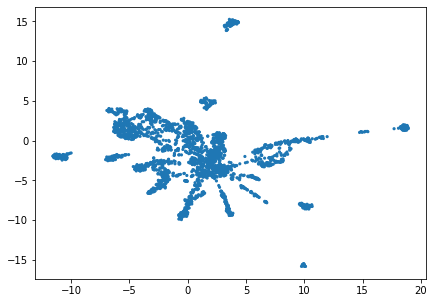

In [52]:
import umap

X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
s = 10, # size
edgecolor='none'
)
plt.show()

In [48]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [51]:
dataset.target

array([17,  0, 17, ...,  9,  4,  9])